In [1]:
pip install numpy pandas scipy openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import math

In [10]:
# 1 Load the dataset
file_path = 'C:/Users/hp952/Data_Nifty_option.xlsx'
df = pd.read_excel(file_path)

In [7]:
df['Risk-Free Rate (r)'] = df['Risk-Free Rate (r)'].astype(float)
df['IV(%)'] = df['IV(%)'].replace('-', np.nan).astype(float)
df['MidPrice'] = df['MidPrice'].astype(float)
df['Strike'] = df['Strike'].astype(float)
df['Spot'] = df['Spot'].astype(float)
df['DTE'] = df['DTE'].astype(float)

In [11]:
# 3. Black-Scholes Implied Volatility Function ===
def bs_price(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2.) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'C':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(option_type, S, K, T, r, market_price):
    try:
        iv = brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - market_price, 1e-6, 5)
    except:
        iv = np.nan
    return iv


In [12]:
# 4. SABR Model Volatility Function (Hagan's formula) ===
def sabr_vol(F, K, T, alpha, beta, rho, nu):
    if F == K:
        term1 = (alpha / (F ** (1 - beta)))
        term2 = (1 + ((1 - beta)**2 * alpha**2) / (24 * F**(2 - 2*beta)) +
                 (rho * beta * nu * alpha) / (4 * F**(1 - beta)) +
                 (2 - 3 * rho**2) * nu**2 / 24) * T
        return term1 * term2
    else:
        logFK = np.log(F / K)
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * logFK
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        term1 = alpha / ((F * K)**((1 - beta) / 2) * (1 + ((1 - beta)**2 / 24) * (logFK**2)))
        term2 = z / x_z
        term3 = 1 + (((1 - beta)**2 * alpha**2) / (24 * (F * K)**(1 - beta)) +
                     (rho * beta * nu * alpha) / (4 * (F * K)**((1 - beta) / 2)) +
                     (2 - 3 * rho**2) * nu**2 / 24) * T
        return term1 * term2 * term3


In [13]:
# SABR Parameters (you can optimize or calibrate these for real use)
beta = 0.5
rho = -0.3
nu = 0.4
alpha = 0.2

In [14]:
# 5. Loop through data to compute IV ===
bs_iv_list = []
sabr_iv_list = []

for i, row in df.iterrows():
    S = row['Spot']
    K = row['Strike']
    T = row['DTE'] / 365
    r = row['Risk-Free Rate (r)']
    option_type = row['OptionType']
    market_price = row['MidPrice']

    bs_iv = implied_volatility(option_type, S, K, T, r, market_price)
    sabr_iv = sabr_vol(S, K, T, alpha, beta, rho, nu)

    bs_iv_list.append(bs_iv)
    sabr_iv_list.append(sabr_iv)


In [15]:
# === 6. Add columns to DataFrame ===
df['IV_BS'] = bs_iv_list
df['IV_SABR'] = sabr_iv_list

# === 7. Save the result ===
df.to_excel('nse_options_iv_output.xlsx', index=False)

print("✅ IVs calculated using Black-Scholes and SABR. Output saved to 'nse_options_iv_output.xlsx'")


✅ IVs calculated using Black-Scholes and SABR. Output saved to 'nse_options_iv_output.xlsx'


C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

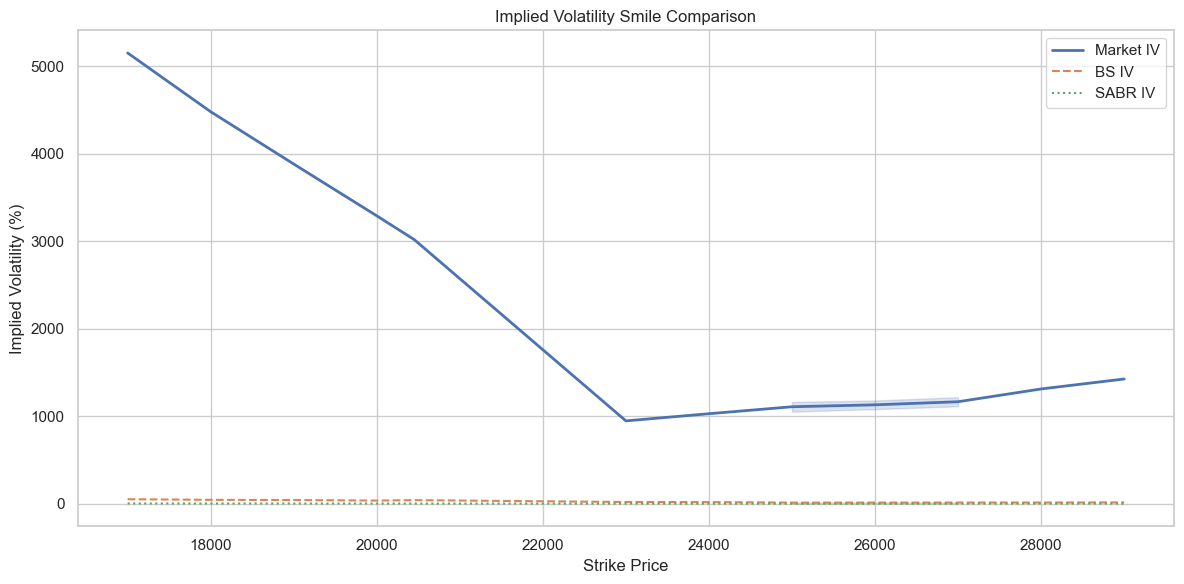

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df already loaded and has 'IV(%)', 'IV_BS', 'IV_SABR', etc.
plot_df = df[df['OptionType'] == 'C'].copy()  # Filter and copy

# Convert back to percentages
plot_df['IV(%)'] *= 100
plot_df['IV_BS'] *= 100
plot_df['IV_SABR'] *= 100

# Clean any bad values
for col in ['IV(%)', 'IV_BS', 'IV_SABR']:
    plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')

# Drop NaN rows
plot_df.dropna(subset=['IV(%)', 'IV_BS', 'IV_SABR', 'Strike'], inplace=True)

# Plot IV vs Strike
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='Strike', y='IV(%)', label='Market IV', linewidth=2)
sns.lineplot(data=plot_df, x='Strike', y='IV_BS', label='BS IV', linestyle='--')
sns.lineplot(data=plot_df, x='Strike', y='IV_SABR', label='SABR IV', linestyle=':')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.title('Implied Volatility Smile Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp952\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

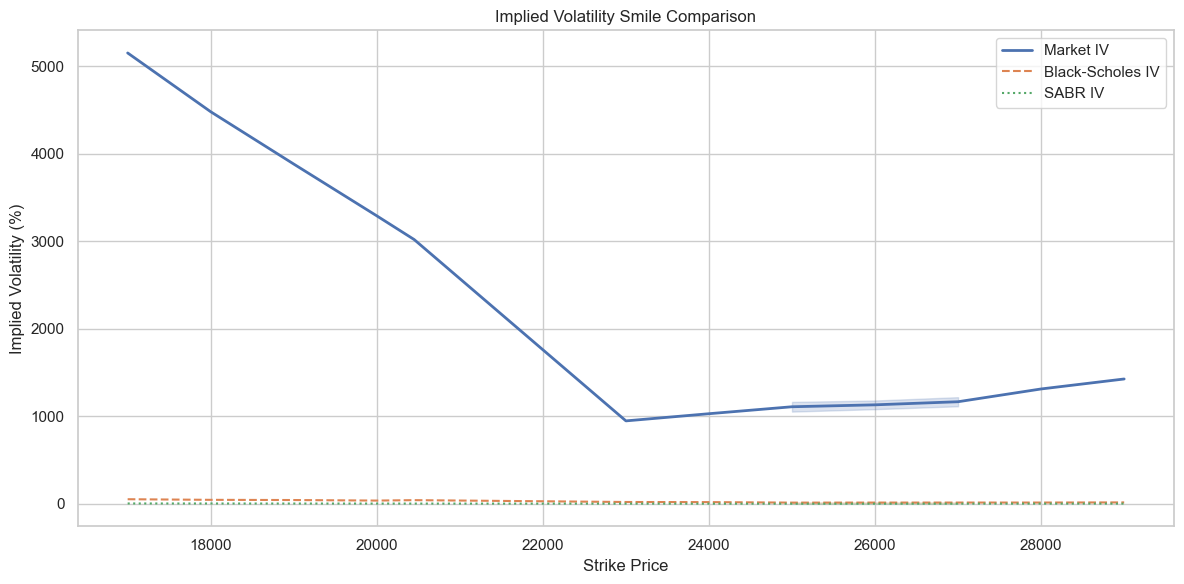

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter only Call options and create a clean copy
plot_df = df[df['OptionType'] == 'C'].copy()

# Step 2: Convert IV columns to numeric BEFORE multiplying
iv_columns = ['IV(%)', 'IV_BS', 'IV_SABR']

for col in iv_columns:
    plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')  # Converts non-numeric to NaN
    plot_df[col] *= 100  # Scale to percentage

# Step 3: Drop rows with missing or invalid IV or Strike data
plot_df = plot_df.dropna(subset=iv_columns + ['Strike'])

# Step 4: Sort for cleaner plot
plot_df = plot_df.sort_values(by='Strike')

# Step 5: Plot the IV smile comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='Strike', y='IV(%)', label='Market IV', linewidth=2)
sns.lineplot(data=plot_df, x='Strike', y='IV_BS', label='Black-Scholes IV', linestyle='--')
sns.lineplot(data=plot_df, x='Strike', y='IV_SABR', label='SABR IV', linestyle=':')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.title('Implied Volatility Smile Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
